In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse

In [ ]:
def build_generator(inputs, image_size):
    """Build a Generator Model

    Stack of BN-ReLU-Conv2DTranpose to generate fake images
    Output activation is sigmoid instead of tanh in [1].
    Sigmoid converges easily.

    Arguments:
        inputs (Layer): Input layer of the generator
            the z-vector)
        image_size (tensor): Target size of one side
            (assuming square image)

    Returns:
        generator (Model): Generator Model
    """

    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    return generator

In [ ]:
def build_discriminator(inputs):
    """Build a Discriminator Model

    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in [1] or original paper.

    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)

    Returns:
        discriminator (Model): Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator

In [ ]:
def train(models, x_train, params):
    """Train the Discriminator and Adversarial Networks

    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly real and fake images.
    Adversarial is trained next with fake images pretending to be real
    Generate sample images per save_interval.

    Arguments:
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters

    """
    # the GAN component models
    generator, discriminator, adversarial = models
    # network parameters
    batch_size, latent_size, train_steps, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # number of elements in train dataset
    train_size = x_train.shape[0]
    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # generate fake images from noise using generator
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # generate fake images
        fake_images = generator.predict(noise)
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0
        # since the discriminator weights
        # are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network
        # note that unlike in discriminator training,
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)

    # save the model after training the generator
    # the trained generator can be reloaded for
    # future MNIST digit generation
    generator.save(model_name + ".h5")

In [ ]:
def plot_images(generator,
                noise_input,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    Arguments:
        generator (Model): The Generator Model for
            fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

In [ ]:
def build_and_train_models():
    # load MNIST dataset
    (x_train, _), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    model_name = "dcgan_mnist"
    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)
    # [1] or original paper uses Adam,
    # but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay = 6e-8)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()

    # build adversarial model
    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    # adversarial = generator + discriminator
    adversarial = Model(inputs,
                        discriminator(generator(inputs)),
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    train(models, x_train, params)

build_and_train_models()

In [ ]:
(x_train, x_test), (y_train, y_test) = mnist.load_data()


11490434/11490434 [==============================] - 2s 0us/step


In [ ]:

#load Model
adversarial = load_model("dcgan_mnist.h5",compile=False)



In [ ]:
def test_generator(generator,input_img):
    noise_input = input_img
    plot_images(generator,
                noise_input=noise_input,
                show=True,
                model_name="test_outputs")






In [ ]:
noise_input = np.random.uniform(-1.0, 1.0, size=[1, 100])
noise_input.shape

(1, 100)

In [ ]:
import requests as rx
from PIL import Image
import io

response = rx.get("https://edwin-de-jong.github.io/blog/mnist-sequence-data/fig/5.png")

# Check if the request was successful.
if response.status_code == 200:

    # Decode the image data.
    image_data = response.content

    # Create a PIL Image object from the image data.
    image = Image.open(io.BytesIO(image_data))

    # Save the image to a file.
    image.save('five.png')

else:

    print('The request failed with status code {}'.format(response.status_code))



In [ ]:
y_train[0]

In [ ]:
image = cv2.imread("five.png")

# Crop the image to a 100x100 size
cropped_image = cv2.resize(image[:,:,1], (100, 100))

# Subsample the image by a factor of 2
subsampled_image = cv2.resize(cropped_image, (100, 100), interpolation=cv2.INTER_AREA)

(100, 100)


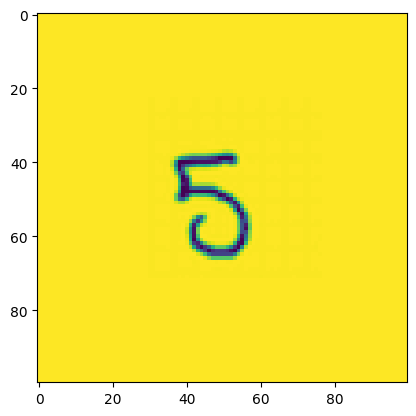

In [ ]:
print(subsampled_image.shape)
plt.imshow(subsampled_image)